In [1]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.circuit.library import CXGate
from qiskit.dagcircuit import DAGOpNode
from qiskit.converters import circuit_to_dag, dag_to_circuit

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import copy
import math

In [2]:
def grayvalue_to_angle(value):
    return value * pi

def grayscale_to_angles(image):
    for i in range(len(image)):
        for j in range(len(image)):
            image[i][j] = grayvalue_to_angle(image[i][j])
    
    return image

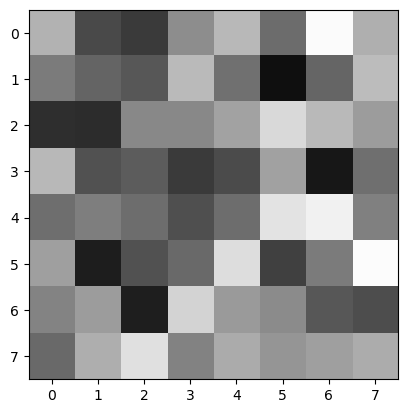

In [3]:
image = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]
]).astype(float)

np.random.seed(123)
rand_image = np.random.rand(8,8)
image = rand_image

image_angles = copy.deepcopy(image)
image_angles = grayscale_to_angles(image_angles)

max_intensity = max([val for row in image for val in row])

_ = plt.imshow(image, cmap='gray', vmin=0, vmax=1)

In [4]:
image_angles

array([[2.18802248, 0.89893323, 0.71267486, 1.73200643, 2.26027843,
        1.32922815, 3.0811616 , 2.15145608],
       [1.51089213, 1.23187351, 1.07812553, 2.2903772 , 1.37781534,
        0.18748364, 1.25049291, 2.31848095],
       [0.57331468, 0.55119795, 1.66991789, 1.67078564, 1.99302939,
        2.66856868, 2.27594353, 1.91958697],
       [2.26962282, 1.01460535, 1.13659258, 0.71711009, 0.92272989,
        1.98226996, 0.2893562 , 1.36251242],
       [1.35359529, 1.55095748, 1.33778531, 0.98099756, 1.33942213,
        2.80666483, 2.96616618, 1.57656641],
       [1.96020601, 0.3632259 , 0.99678174, 1.30321498, 2.72159049,
        0.78682874, 1.5174969 , 3.09622738],
       [1.63201063, 1.92546494, 0.37896613, 2.59602619, 1.89456927,
        1.71238164, 1.07682434, 0.95542364],
       [1.31011391, 2.14036948, 2.75032878, 1.60353907, 2.10271126,
        1.84077397, 1.96319225, 2.11959817]])

In [5]:
intensities = [i for image_row in image for i in image_row]
sqrt_intensities = [np.sqrt(i) for i in intensities]
scaled_intensities = [i*(1/np.sqrt(sum(intensities))) for i in sqrt_intensities]
# print(intensities)

In [6]:
qc = QuantumCircuit(7)

# initialization to match amplitudes
qc.h([i for i in range(6)])
for i in range(len(image_angles)):
    for j in range(len(image_angles[i])):
        theta = image_angles[i][j]
        
        pos = i*len(image_angles) + j
        bin_pos = str(bin(pos))[2:]
        bin_pos = '0'*(6-len(bin_pos)) + bin_pos
        bin_pos = [int(i) for i in bin_pos]
        
        filter_low = []
        for k in range(len(bin_pos)):
            if bin_pos[k] == 0:
                filter_low.append(k)
                qc.x(k)
        
        qc.mcrx(theta, [i for i in range(6)], 6)
        if len(filter_low) > 0:
            qc.x(filter_low)

qc.measure_all()

# qc.draw()

{'1101100': 3, '0111101': 1, '1011110': 6, '0001101': 19, '1100000': 95, '1101101': 84, '0111100': 73, '1100010': 38, '1000010': 35, '0010010': 216, '0100111': 89, '0001011': 190, '1101000': 179, '1011100': 165, '1010101': 120, '0111111': 133, '1010011': 23, '0001010': 143, '1111000': 398, '0101001': 11, '1000111': 162, '1001000': 428, '1000100': 241, '0111000': 114, '0000100': 263, '1111001': 303, '0101101': 421, '0011111': 157, '1010110': 156, '1001101': 508, '1100100': 155, '1111110': 191, '1100101': 19, '0101000': 319, '0001110': 416, '1000000': 401, '0001100': 311, '1010000': 62, '1111100': 439, '0100011': 177, '1001001': 202, '0010011': 476, '1110111': 281, '1110000': 288, '1110010': 292, '1001011': 350, '1110100': 417, '1100011': 375, '1100110': 119, '0100010': 453, '1011101': 238, '0010111': 24, '0011000': 1, '0010110': 344, '0110001': 405, '0010001': 296, '0101011': 218, '1111010': 352, '0001111': 140, '0110101': 346, '0011001': 3, '1110011': 466, '0101111': 196, '0101010': 33

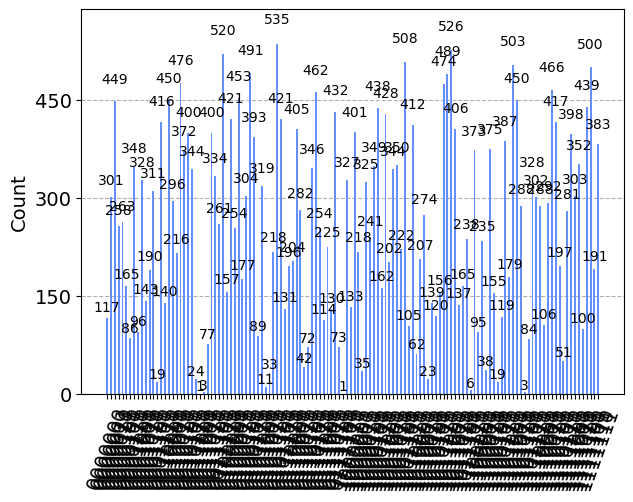

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=2**15)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)

print(counts)
plot_histogram(counts)

In [9]:
# Image reconstruction
rec_image_components = [[[0, 0] for _ in range(8)] for _ in range(8)]
highest_count = max(counts.values())

for k in counts.keys():
    color = k[0]
    qubit = k[1:][::-1]
    pos = int(qubit, 2)
    row = math.floor(pos / len(image))
    col = pos % len(image[row])
    rec_image_components[row][col][int(color)] = counts[k]

In [10]:
rec_image = [[0 for _ in range(8)] for _ in range(8)]

for i in range(8):
    for j in range(8):
        if sum(rec_image_components[i][j]) > 0:
            rec_image[i][j] = rec_image_components[i][j][1]/sum(rec_image_components[i][j])
            
print(rec_image_components)

[[[117, 401], [421, 95], [450, 62], [204, 288], [96, 428], [319, 179], [1, 489], [114, 398]], [[263, 241], [304, 155], [372, 139], [72, 417], [311, 222], [535, 3], [334, 165], [73, 439]], [[449, 35], [453, 38], [216, 274], [282, 292], [143, 344], [33, 450], [77, 406], [130, 352]], [[86, 438], [393, 119], [344, 156], [462, 51], [416, 105], [131, 328], [520, 6], [327, 191]], [[301, 218], [254, 235], [296, 207], [405, 106], [328, 202], [11, 503], [3, 526], [225, 303]], [[165, 349], [491, 19], [400, 120], [346, 197], [19, 508], [421, 84], [261, 238], [1, 500]], [[258, 325], [177, 375], [476, 23], [42, 466], [190, 350], [218, 288], [400, 137], [432, 100]], [[348, 162], [89, 387], [24, 474], [254, 281], [140, 412], [196, 302], [157, 373], [133, 383]]]


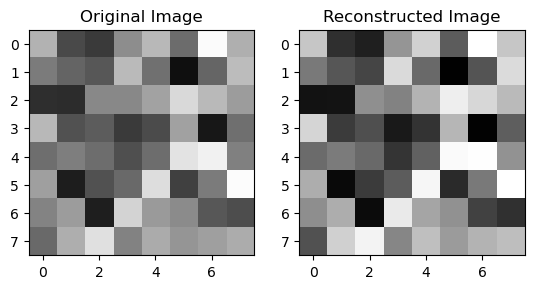

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

_ = ax1.imshow(image, cmap='gray', vmin=0, vmax=1)
_ = ax1.set_title('Original Image')

_ = ax2.imshow(rec_image, cmap='gray', vmin=0, vmax=1)
_ = ax2.set_title('Reconstructed Image')

In [12]:
image_diff = image - rec_image
squared_diff = 0
for i in range(len(image_diff)):
    for j in range(len(image_diff[i])):
        squared_diff += image_diff[i][j]**2

print('Squared error:', squared_diff)

Squared error: 0.38434619267641895
